# EQUIX

In [1]:
import cf_xarray
import dcpy
import eddydiff
import xgcm

import distributed
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pump
import xarray as xr
from dcpy.oceans import read_osu_microstructure_mat
from IPython.display import Image
from scipy.io import loadmat

import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")

## Todo


- [x] See if IOP variance terms match chameleon
- [x] is there a consolidated TAO data file
- [x] are they in the PMEL TAO files?
- [ ] use 10 min averages to calculate KT, Jq
- [ ] What is happening with the top few bins
- [x] Take out Chameleon MLD properly not just slice it out
- [x] filter χpod bad estimates using dT/dz - already done
- [x] filter out binned estimates using count

- [ ] pick bins that don't outcrop?
- [ ] try chameleon dTdz using xgcm transform
- [ ] look at T-S diagram north, south of the equator

## Data file notes

`indus/chipod/eq08_long/processed/chi_analysis/deglitched/`
1. `allchi_eq08_long.mat` EQUIX EOP APL mooring; renamed to `equix_eop.mat`
2. `mean_chi_*.mat` seem to be IOP files per χpod

EOP units: 204 205 304 312 314 315 328


mean_chi vs summary files

1. summary files: T1, T2, AZ etc.
2. mean_chi files: T1, T2, eps, chi, KT, Jq

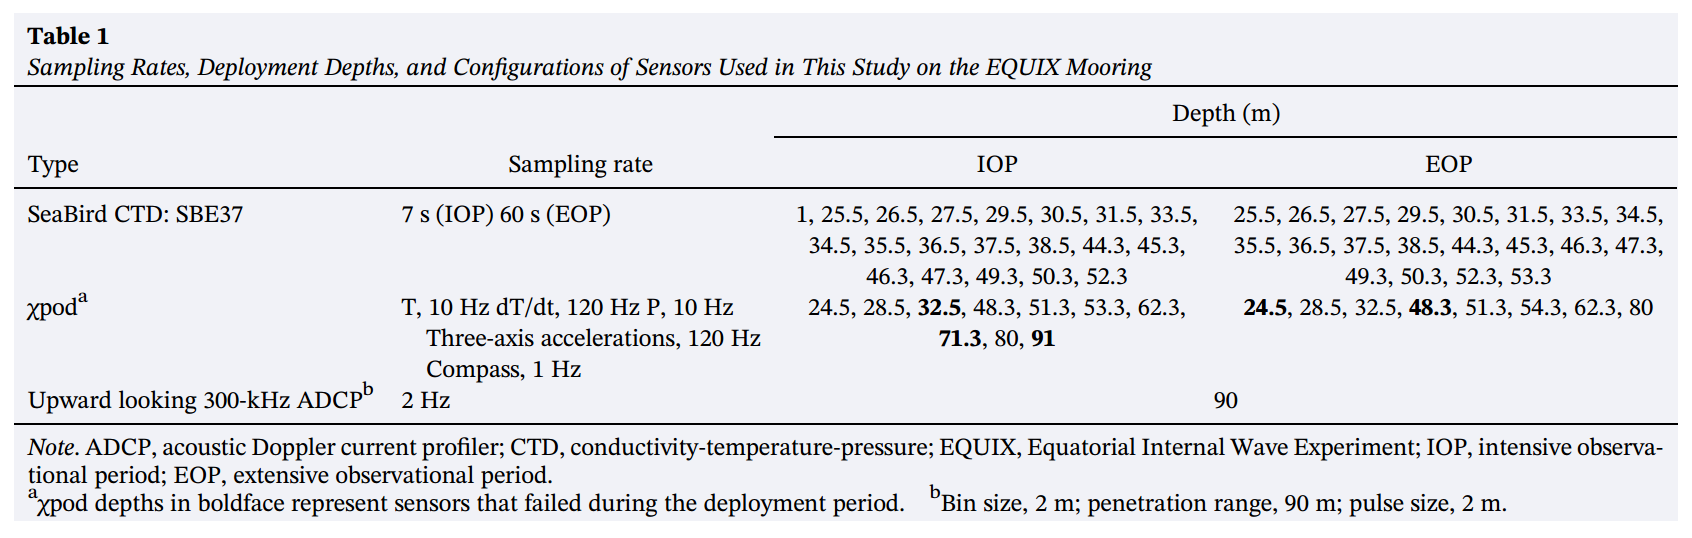

In [2]:
Image("../images/equix-chipods.png")

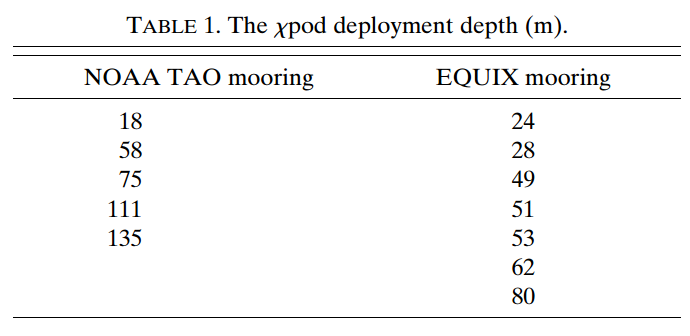

In [3]:
Image("../images/equix-tao-chipods.png")

## Chameleon

In [4]:
chameleon = xr.open_dataset("/home/deepak/datasets/microstructure/osu/equix.nc")
del chameleon["dTdz"]  # not potential temperature?
chameleon = ed.sections.add_ancillary_variables(chameleon)
# take out ML
chameleon = chameleon.where(chameleon.depth > chameleon.mld)
chameleon = chameleon.cf.set_coords(["latitude", "longitude"])
chameleon

<xarray.Dataset>
Dimensions:      (depth: 200, time: 2624, zeuc: 80)
Coordinates:
  * depth        (depth) uint64 1 2 3 4 5 6 7 8 ... 194 195 196 197 198 199 200
    lon          (time) float64 -139.9 -139.9 -139.9 ... -139.9 -139.9 -139.9
    lat          (time) float64 0.06246 0.0622 0.06263 ... 0.06317 0.06341
  * time         (time) datetime64[ns] 2008-10-24T20:36:23 ... 2008-11-08T19:...
  * zeuc         (zeuc) float64 -200.0 -195.0 -190.0 ... 185.0 190.0 195.0
Data variables: (12/46)
    pmax         (time, depth) float64 nan nan 205.9 205.9 ... 203.9 203.9 203.9
    castnumber   (time, depth) float64 nan nan 16.0 ... 2.668e+03 2.668e+03
    AX_TILT      (depth, time) float64 nan nan nan nan ... 0.7031 4.232 1.28
    AY_TILT      (depth, time) float64 nan nan nan nan ... -2.623 -2.121 0.05032
    AZ2          (depth, time) float64 nan nan nan ... 2.612e-06 3.208e-06
    C            (depth, time) float64 nan nan nan nan ... 4.135 4.137 4.164
    ...           ...
    chi_masked   (depth, time) float64 nan nan nan ... 4e-09 2.592e-09 9.245e-09
    Krho         (depth, time) float64 nan nan nan ... 2.642e-05 9.09e-06
    KrhoTz       (depth, time) float64 nan nan nan ... 2.195e-06 4.328e-07
    eps_chi      (depth, time) float64 nan nan nan ... 4.389e-11 5.913e-10
    Kt           (depth, time) float64 nan nan nan ... 1.877e-07 2.039e-06
    KtTz         (depth, time) float64 nan nan nan ... 1.559e-08 9.708e-08
Attributes:
    starttime:  ['Time:20:34:29 298   ' 'Time:20:42:18 298   ' 'Time:20:52:14...
    endtime:    ['Time:20:38:29 298   ' 'Time:20:46:29 298   ' 'Time:20:56:29...
    name:       EQUIX

## Read climatologies

In [5]:
argograd = xr.open_zarr(
    "../datasets/argo_monthly_iso_gradients.zarr", decode_times=False
)
argograd.Smean.attrs = {"standard_name": "sea_water_salinity"}
argograd.Tmean.attrs = {"standard_name": "sea_water_potential_temperature"}
argograd["temp"] = dcpy.eos.temp(argograd.Smean, argograd.Tmean, argograd.pres, 0)
argograd = argograd.cf.guess_coord_axis()
argograd.pres.attrs.update({"positive": "down", "standard_name": "sea_water_pressure"})
argograd = argograd.cf.add_bounds("pres")
argo = (
    argograd.sel(lon=220, method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(300))
    .mean("time")
)
argo["pden"] = ed.jmd95.dens(argo.Smean, argo.Tmean, 0)
argo["gamma_n"] = dcpy.oceans.neutral_density(argo)
argo

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 11, pres: 25)
Coordinates:
  * lat          (lat) float32 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5
    lon          float32 220.5
  * pres         (pres) float64 2.5 10.0 20.0 30.0 ... 240.0 260.0 280.0 300.0
    pres_bounds  (bounds, pres) float32 -1.25 6.25 15.0 ... 270.0 290.0 310.0
Dimensions without coordinates: bounds
Data variables:
    Smean        (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    Tmean        (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    dSdia        (pres, lat) float64 dask.array<chunksize=(25, 11), meta=np.ndarray>
    dSdz         (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    dSiso        (pres, lat) float64 dask.array<chunksize=(25, 11), meta=np.ndarray>
    dTdia        (pres, lat) float64 dask.array<chunksize=(25, 11), meta=np.ndarray>
    dTdz         (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    dTiso        (pres, lat) float64 dask.array<chunksize=(25, 11), meta=np.ndarray>
    ρmean        (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    temp         (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    pden         (pres, lat) float32 dask.array<chunksize=(25, 11), meta=np.ndarray>
    gamma_n      (lat, pres) float32 dask.array<chunksize=(11, 25), meta=np.ndarray>
Attributes:
    dataset:  argo
    name:     Mean fields and isopycnal, diapycnal gradients from Argo

In [6]:
ecco = ed.read_ecco_clim().sel(lon=220, method="nearest").sel(lat=slice(-3, 8), pres=slice(300)).mean("time")
ecco["gamma_n"] = dcpy.oceans.neutral_density(ecco)
ecco

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 22, pres: 20)
Coordinates:
  * lat          (lat) float64 -2.75 -2.25 -1.75 -1.25 ... 6.25 6.75 7.25 7.75
    lon          float64 220.2
  * pres         (pres) float64 5.0 15.0 25.0 35.0 ... 194.7 222.7 257.5 299.9
    pres_bounds  (bounds, pres) float64 0.0 10.0 20.0 30.0 ... 236.7 274.8 321.2
Dimensions without coordinates: bounds
Data variables:
    RHOAnoma     (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    Smean        (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    Tmean        (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    dSdia        (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    dSdz         (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    dSiso        (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    dTdia        (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    dTdz         (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    dTiso        (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    pden         (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    temp         (pres, lat) float64 dask.array<chunksize=(20, 6), meta=np.ndarray>
    gamma_n      (lat, pres) float64 dask.array<chunksize=(6, 20), meta=np.ndarray>
Attributes:
    dataset:  ecco
    name:     Mean fields and isopycnal, diapycnal gradients from ECCO v4r3

## Read χpod data

In [7]:
equix_iop = xr.load_dataset("/home/deepak/datasets/microstructure/osu/equix/iop.nc")
equix_iop.coords["kind"] = ("depth", ["APL"] * equix_iop.sizes["depth"])

tao_iop= (
    xr.load_dataset("/home/deepak/datasets/microstructure/osu/equix/tao_may08.nc")
    .reindex(time=equix_iop.time)
    .drop_sel(depth=[39, 84])
)
tao_iop.coords["kind"] = ("depth", ["TAO"] * tao_iop.sizes["depth"])

# depths are quite different so simple merge works.
# clusters of 3 χpods are also separated
iop_ = xr.merge([tao_iop, equix_iop])

iop = iop_[["theta", "chi", "eps", "dTdz"]].coarsen(time=10, boundary="trim").mean()
iop["salt"] = 35 * xr.ones_like(iop.theta)
iop["salt"].attrs = {"standard_name": "sea_water_salinity"}
iop["theta"].attrs = {"standard_name": "sea_water_temperature"}
iop["pres"] = iop.depth
iop["pres"].attrs = {"standard_name": "sea_water_pressure"}
iop.coords["latitude"] = 0
iop.coords["longitude"] = -140
iop = iop.cf.guess_coord_axis()
iop = ed.sections.add_ancillary_variables(iop)
iop

<xarray.Dataset>
Dimensions:             (depth: 12, time: 2256)
Coordinates:
  * depth               (depth) int64 18 24 28 49 51 53 59 62 69 80 124 150
  * time                (time) datetime64[ns] 2008-10-24T07:05:00 ... 2008-11...
    unit                (depth) float64 313.0 nan nan nan ... nan 327.0 321.0
    kind                (depth) object 'TAO' 'APL' 'APL' ... 'APL' 'TAO' 'TAO'
    actual_depth        (depth, time) float64 nan nan nan nan ... nan nan nan
    latitude            int64 0
    longitude           int64 -140
    reference_pressure  int64 0
Data variables: (12/15)
    theta               (depth, time) float64 24.49 24.51 24.5 ... 16.74 16.88
    chi                 (depth, time) float64 1.617e-06 3.078e-06 ... 2.275e-10
    eps                 (depth, time) float64 7.304e-06 1.578e-05 ... 1.673e-10
    Tz                  (depth, time) float64 0.002167 0.0036 ... 0.1626 0.01216
    salt                (depth, time) float64 35.0 35.0 35.0 ... 35.0 35.0 35.0
    pres                (depth) int64 18 24 28 49 51 53 59 62 69 80 124 150
    ...                  ...
    chi_masked          (depth, time) float64 1.617e-06 3.078e-06 ... 2.275e-10
    Krho                (depth, time) float64 0.02864 0.05469 ... 2.409e-07
    KrhoTz              (depth, time) float64 6.205e-05 0.0001969 ... 2.93e-09
    eps_chi             (depth, time) float64 4.392e-05 3.427e-05 ... 5.343e-10
    Kt                  (depth, time) float64 0.1722 0.1188 ... 7.692e-07
    KtTz                (depth, time) float64 0.0003731 0.0004276 ... 9.355e-09

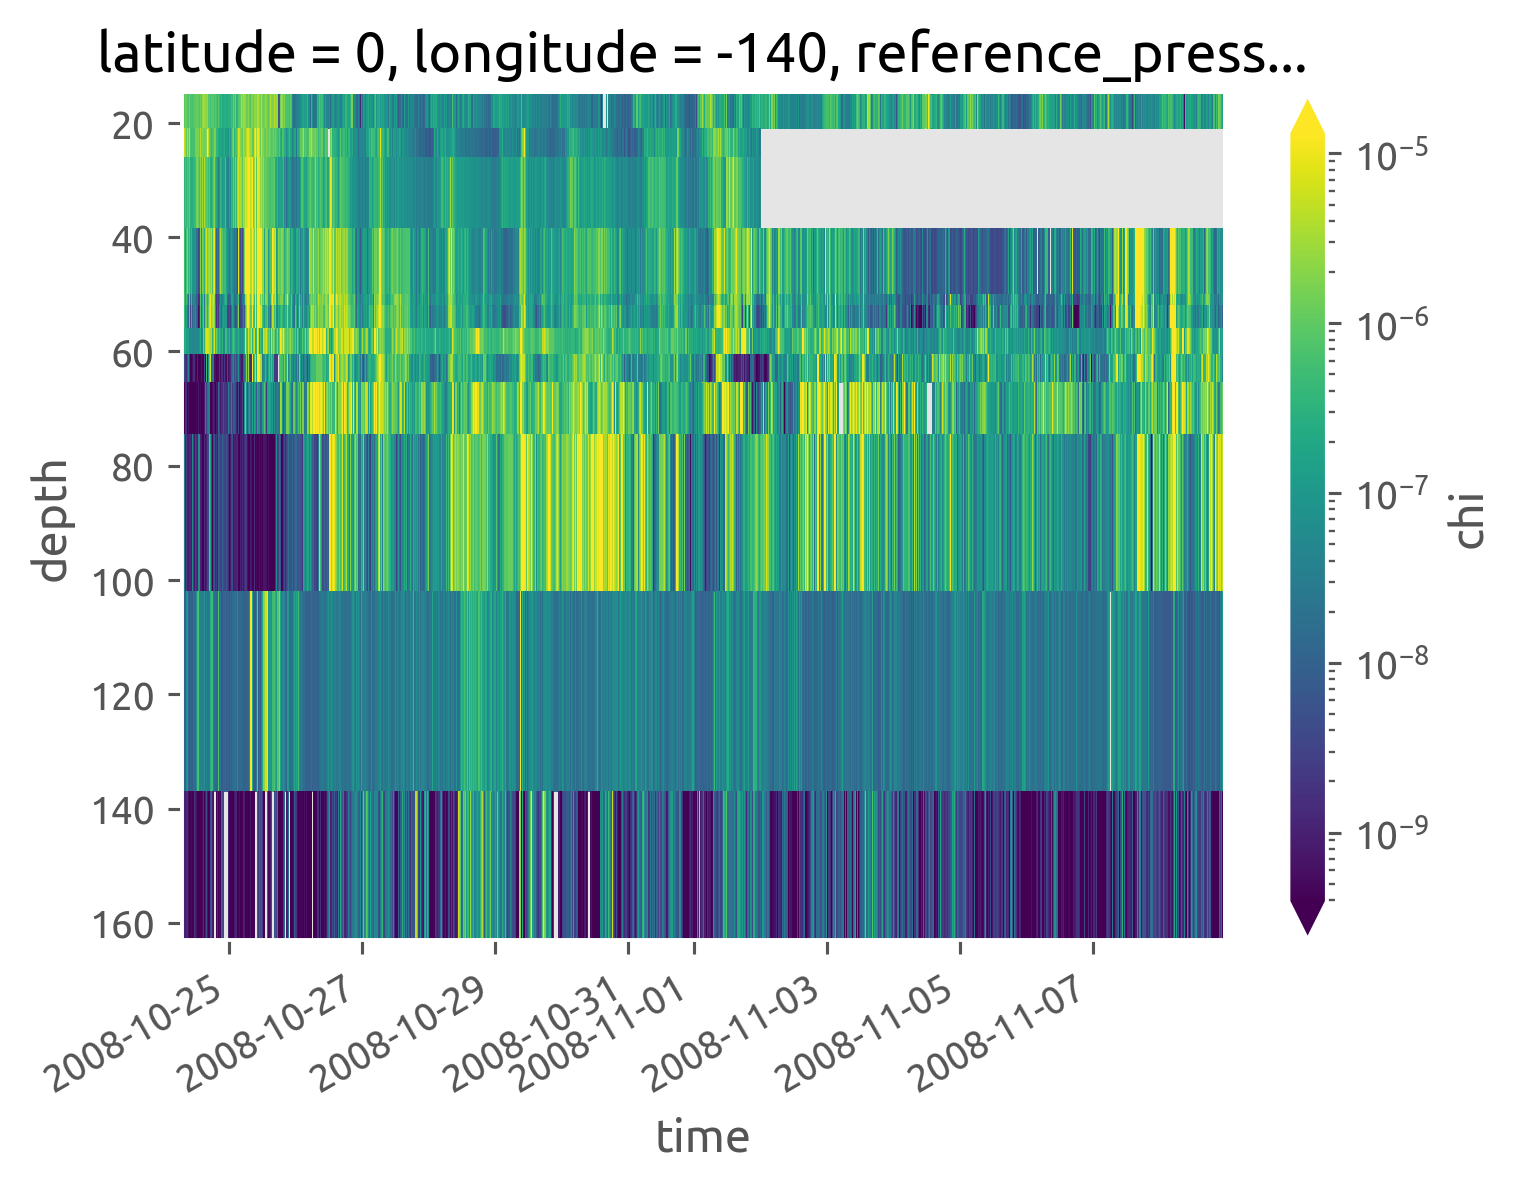

In [8]:
iop.chi.cf.plot(robust=True, norm=mpl.colors.LogNorm())

## Do ancillary variables

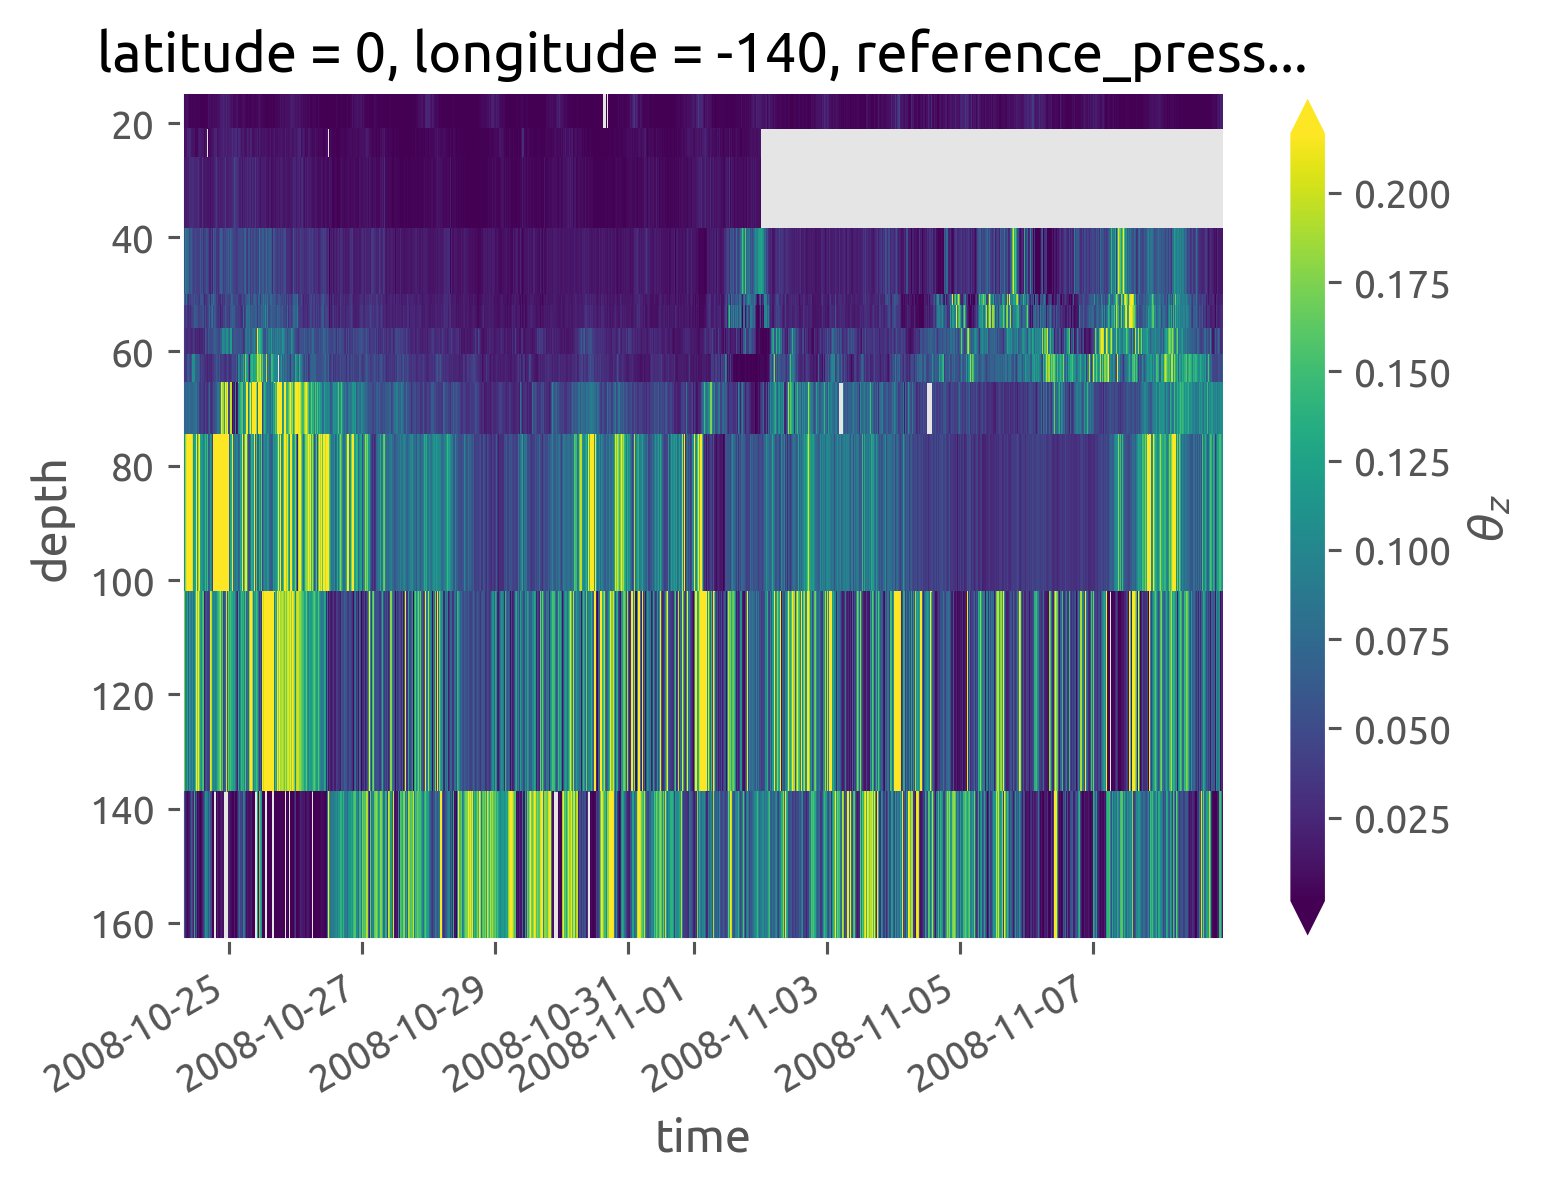

In [9]:
iop.Tz.cf.plot(robust=True)

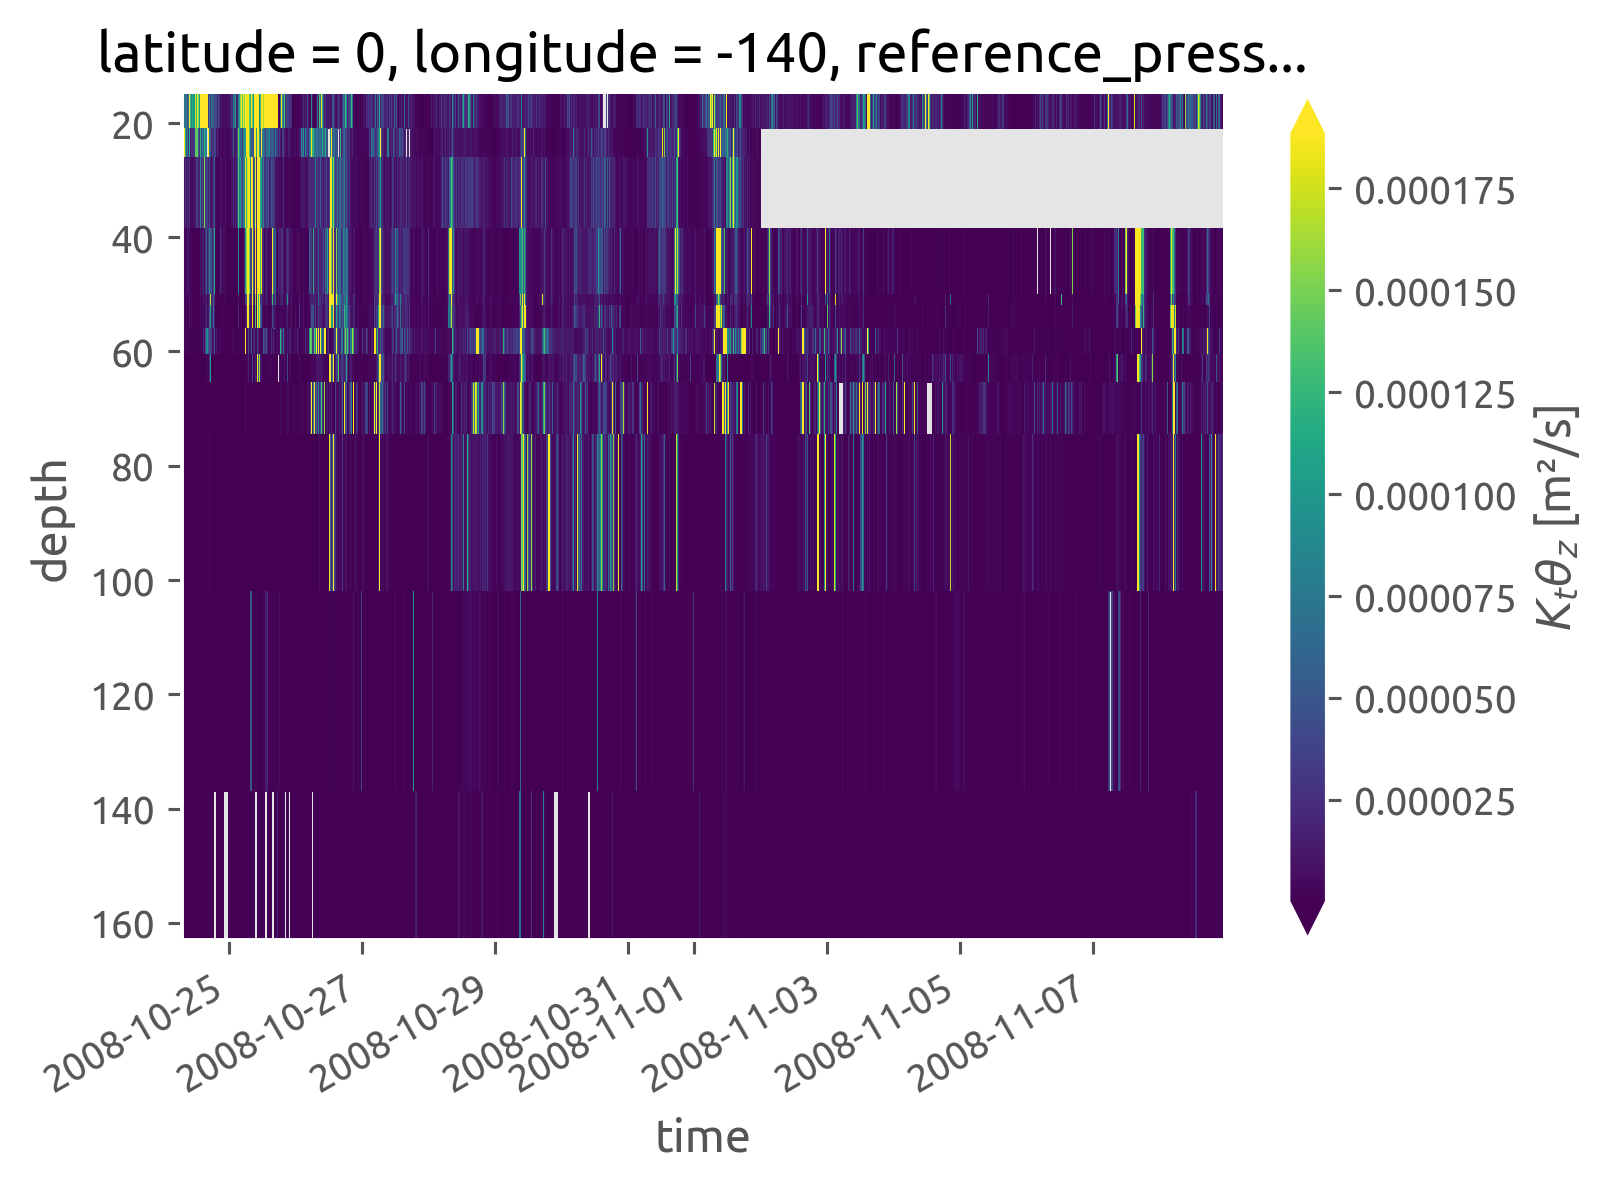

In [10]:
iop.KtTz.cf.plot(robust=True)

## IOP: χpod vs Chameleon

Not sure why this does not totally agree with Perlin & Moum

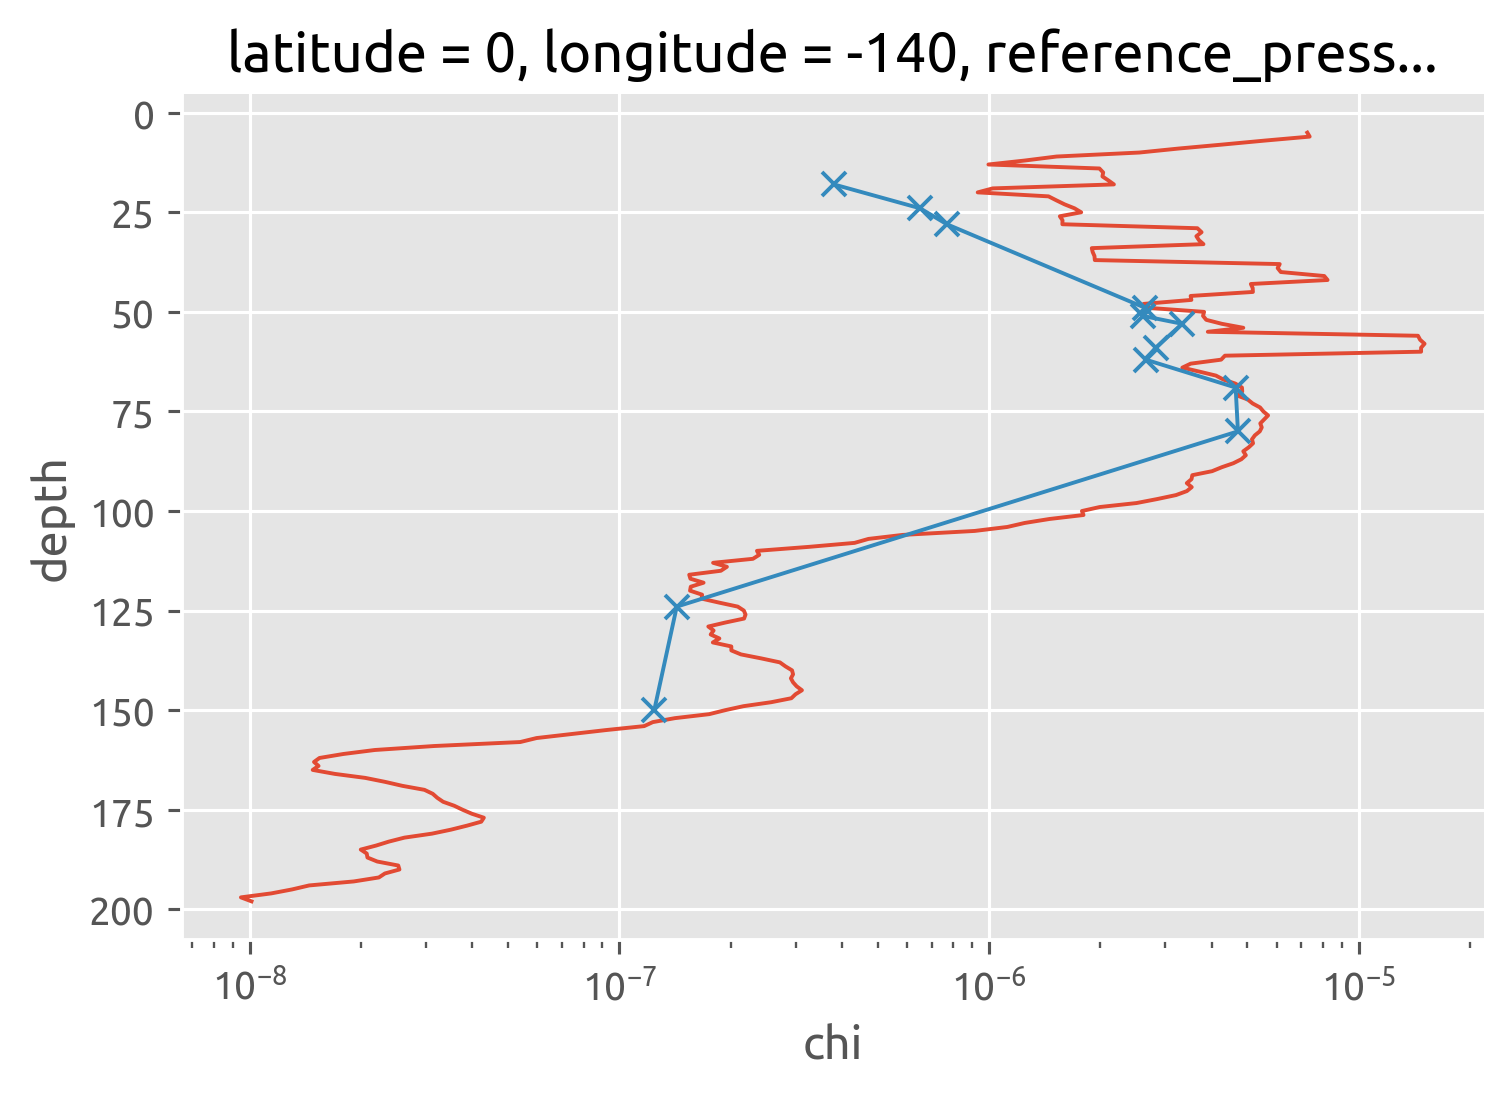

In [11]:
chameleon.chi.mean("time").rolling(depth=5, center=True).mean().cf.plot()
iop.chi.mean("time").cf.plot(marker="x", xscale="log")

### bin-averaging in density space

In [10]:
bins = ed.sections.choose_bins(
    chameleon.cf["neutral_density"], depth_range=np.arange(20, 200, 15)
)

cham_dens = ed.sections.bin_average_vertical(chameleon, "neutral_density", bins)

iop_dens = ed.sections.bin_average_vertical(
    iop.where(iop.Tz > 5e-3), "neutral_density", bins, skip_fits=True
)

In [11]:
tao_dens = ed.sections.bin_average_vertical(
    iop.where(iop.Tz > 5e-3).query(depth="kind == 'TAO'"),
    "neutral_density",
    bins,
    skip_fits=True,
)

apl_dens = ed.sections.bin_average_vertical(
    iop.where(iop.Tz > 5e-3).query(depth="kind == 'APL'"),
    "neutral_density",
    bins,
    skip_fits=True,
)

In [12]:
chipod_dens = xr.concat([iop_dens, tao_dens, apl_dens], dim="kind")
chipod_dens["kind"] = ["iop", "TAO", "APL"]

# χpod depths are useless as a mean pressure
# we need to remap using the mean; here we use chameleon for now
# could use Argo et al later
chipod_dens = chipod_dens.rename({"pres": "χpod_pres"})
chipod_dens.coords["pres"] = cham_dens["pres"].reset_coords(drop=True)

for var in cham_dens:
    cham_dens[var].attrs["coordinates"] = "pres"

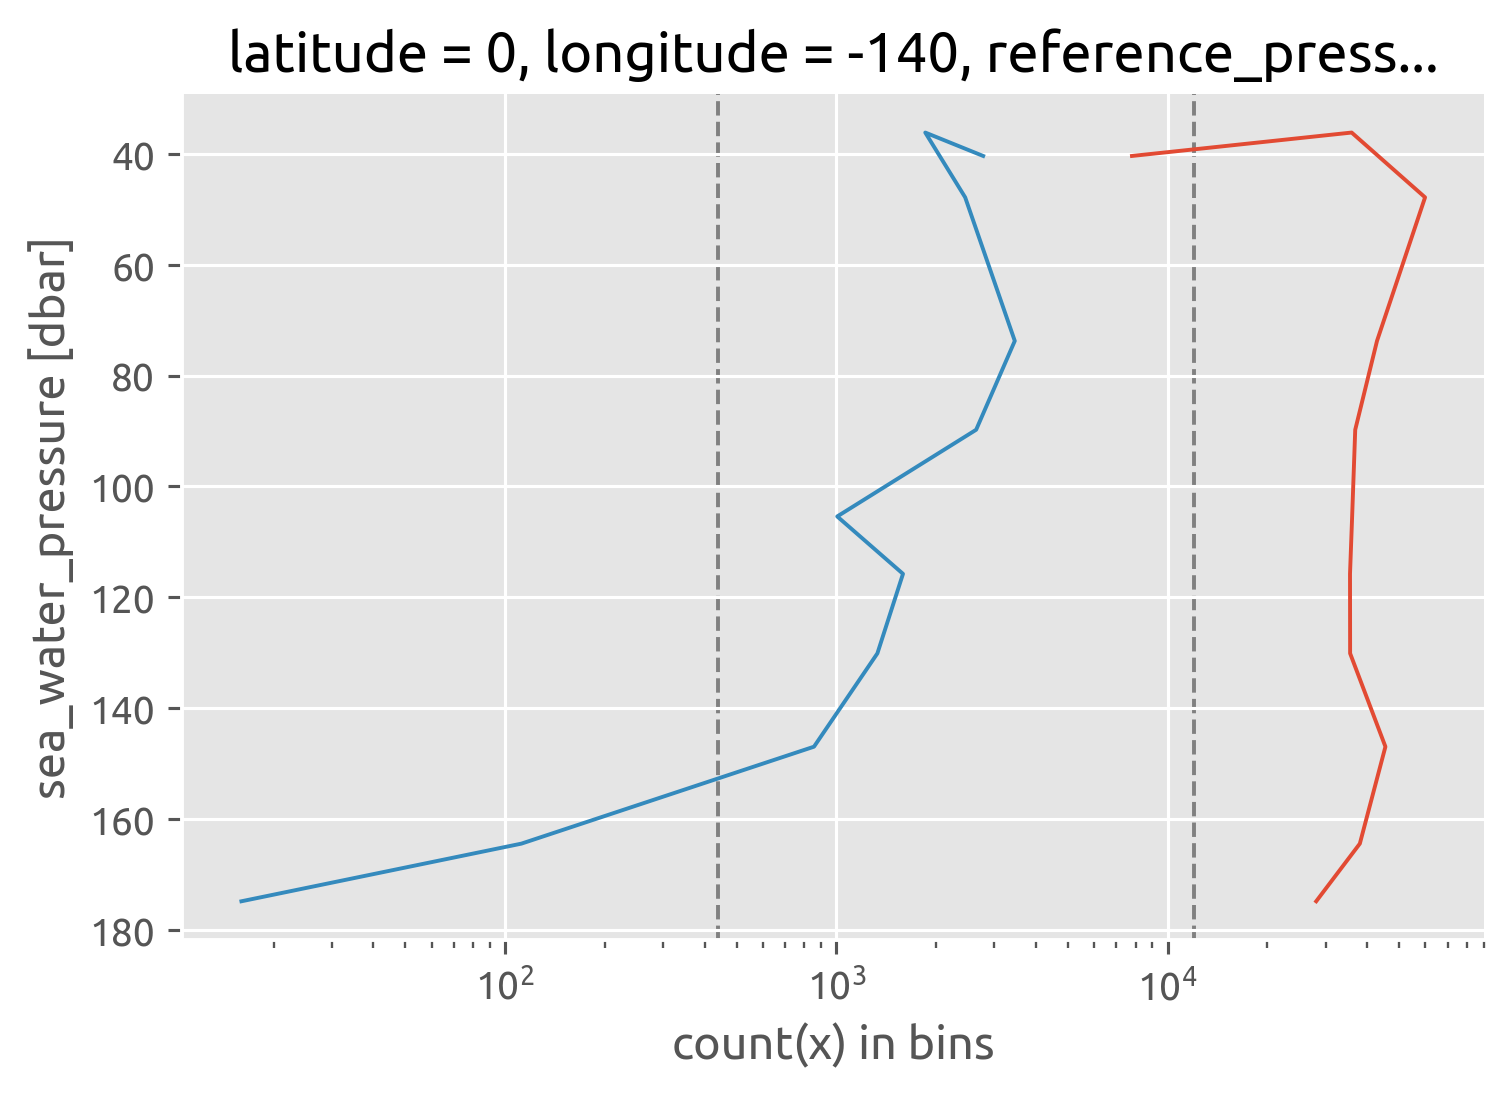

In [14]:
cham_dens.num_obs.cf.plot(y="pres")
chipod_dens.num_obs.sel(kind="iop").cf.plot(y="pres", xscale="log")
dcpy.plots.linex([cham_dens.num_obs.median()/3, chipod_dens.num_obs.median()/3])

### final result


This was wrong earlier :X. I forgot to do χ/2  with the χpod estimate

χpods say no difference i.e. there doesn't seem to be any eddy stirring

Old notes:
Mostly agree. 
- It looks like  the biggest disagreement is between 100m and 120m ≈ EUCmax. 
- Note that I have used the chameleon $∂_zθ^m$
- crosses need to be moved one half-bin width down

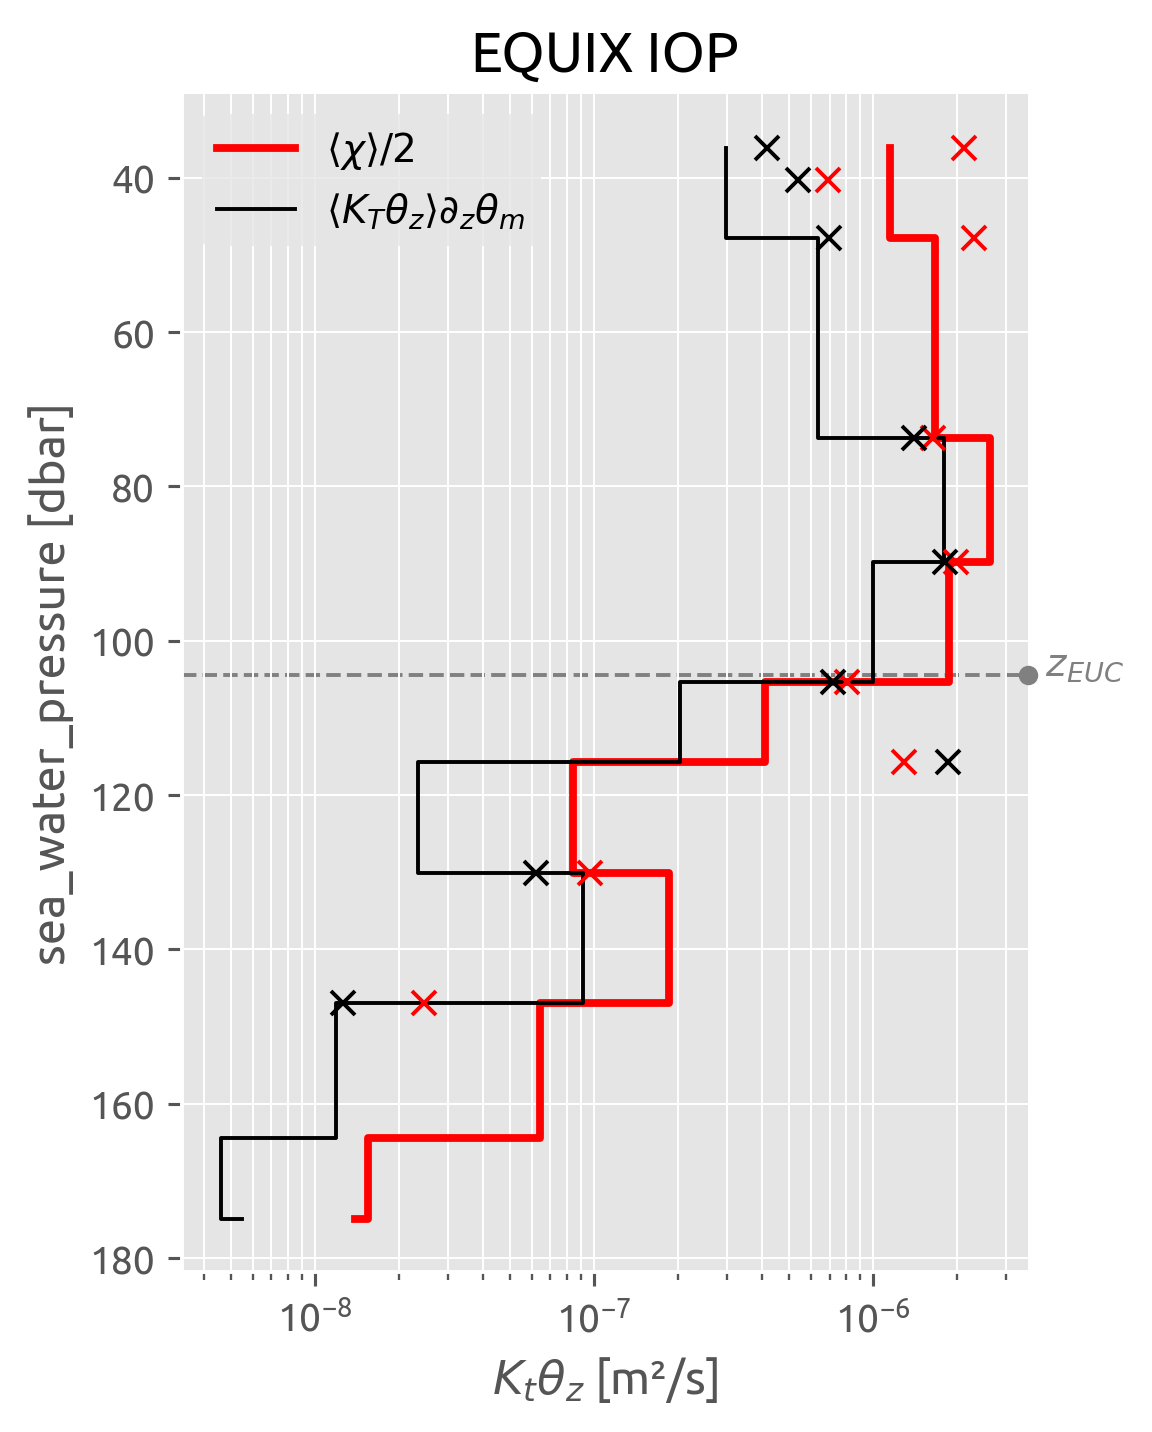

In [15]:
chipodmask = chipod_dens.num_obs > chipod_dens.num_obs.median() / 3
chammask = cham_dens.num_obs > cham_dens.num_obs.median() / 3

ed.sections.plot_var_prod_diss(cham_dens.where(chammask))
(chipod_dens.chi / 2).where(chipodmask).sel(kind="iop").cf.plot(
    y="pres", color="r", ls="none", marker="x"
)
(chipod_dens.where(chipodmask).KtTz * cham_dens.dTdz_m).sel(kind="iop").cf.plot(
    y="pres", marker="x", ls="none", color="k"
)
plt.title("EQUIX IOP")
hdl = dcpy.plots.liney(chameleon.eucmax.mean().values, label="$z_{EUC}$")

In [ ]:
chipod_dens.where(chipod_dens.num_obs > 600).sel(kind="iop").chi.cf.plot.step(y="pres")
chipod_dens.where(chipod_dens.num_obs > 250).sel(kind="TAO").chi.cf.plot.step(y="pres")
chipod_dens.where(chipod_dens.num_obs > 250).sel(kind="APL").chi.cf.plot.step(y="pres")

## EQUIX EOP

- [ ] need salinity
- [ ] merge in TAO
- [ ] need to preserve time dimension while grouping

In [16]:
equix_eop = xr.open_dataset(
    "/home/deepak/datasets/microstructure/osu/equix/hourly_eop.nc"
).rename({"dTdz": "Tz"})
equix_eop["depth"] = equix_eop.depth.data.astype(int)
equix_eop["salt"] = 35 * xr.ones_like(equix_eop.theta)
equix_eop["salt"].attrs = {"standard_name": "sea_water_salinity"}
equix_eop["T"] = dcpy.eos.temp(equix_eop.salt, equix_eop.theta, equix_eop.depth)
equix_eop.coords["pres"] = dcpy.eos.pres(equix_eop.depth, 0)
equix_eop.coords["latitude"] = 0
equix_eop.coords["longitude"] = -140
equix_eop = equix_eop.cf.guess_coord_axis()
equix_eop["gamma_n"] = dcpy.oceans.neutral_density(equix_eop)
equix_eop["pden"] = dcpy.eos.pden(equix_eop.salt, equix_eop.theta, 0)
equix_eop.attrs["name"] = "EQUIX"

tao = xr.open_dataset("/home/deepak/datasets/microstructure/osu/equix/hourly_tao.nc")
tao.attrs["name"] = "TAO"

tao_eop = dcpy.util.slice_like(tao, equix_eop.time).drop_sel(depth=[39, 84])
eop = xr.merge([tao_eop, equix_eop])
eop

<xarray.Dataset>
Dimensions:             (depth: 11, time: 2692)
Coordinates:
  * depth               (depth) int64 18 25 29 47 49 58 59 69 76 124 150
  * time                (time) datetime64[ns] 2008-11-11T05:00:00 ... 2009-03...
    unit                (depth) float64 313.0 315.0 328.0 ... 304.0 327.0 321.0
    pres                (depth) float64 nan 25.15 29.17 47.28 ... 76.47 nan nan
    latitude            int64 0
    longitude           int64 -140
    reference_pressure  int64 0
Data variables:
    theta               (time, depth) float64 24.77 24.62 24.51 ... 18.66 15.89
    chi                 (time, depth) float64 2.222e-07 7.709e-08 ... 2.5e-07
    eps                 (time, depth) float64 4.368e-07 6.169e-08 ... 7.051e-09
    Kt                  (time, depth) float64 0.008625 0.0002651 ... 3.797e-06
    Jq                  (time, depth) float64 98.86 13.11 40.81 ... 1.153 2.633
    dTdz                (time, depth) float64 0.008565 nan ... 0.06073 0.2235
    Tz                  (time, depth) float64 nan 0.01206 0.005363 ... nan nan
    KtTz                (time, depth) float64 nan 3.196e-06 ... nan nan
    salt                (time, depth) float64 nan 35.0 35.0 ... 35.0 nan nan
    T                   (time, depth) float64 nan 24.62 24.52 ... 21.78 nan nan
    gamma_n             (time, depth) float64 nan 23.46 23.49 ... 24.29 nan nan
    pden                (time, depth) float64 nan 1.023e+03 ... nan nan

<xarray.Dataset>
Dimensions:         (bounds: 2, gamma_n: 11)
Coordinates:
    lon             float64 220.2
  * gamma_n         (gamma_n) float64 23.54 23.67 23.84 ... 25.96 26.16 26.28
    gamma_n_bounds  (bounds, gamma_n) float64 23.49 23.59 23.74 ... 26.23 26.33
    dz_remapped     (gamma_n) float64 7.004 8.579 10.3 13.2 ... 21.8 18.04 17.01
    pres            (gamma_n) float64 57.03 64.82 74.26 ... 174.0 193.9 211.4
    y               float64 0.0
    lat             int64 0
Dimensions without coordinates: bounds
Data variables:
    Tmean           (gamma_n) float64 24.9 24.59 24.12 ... 15.3 14.32 13.66
    dTdy            (gamma_n) float64 -3.753e-06 -3.315e-06 ... -1.896e-06
    dTdz            (gamma_n) float64 0.03738 0.04391 ... 0.04075 0.03307

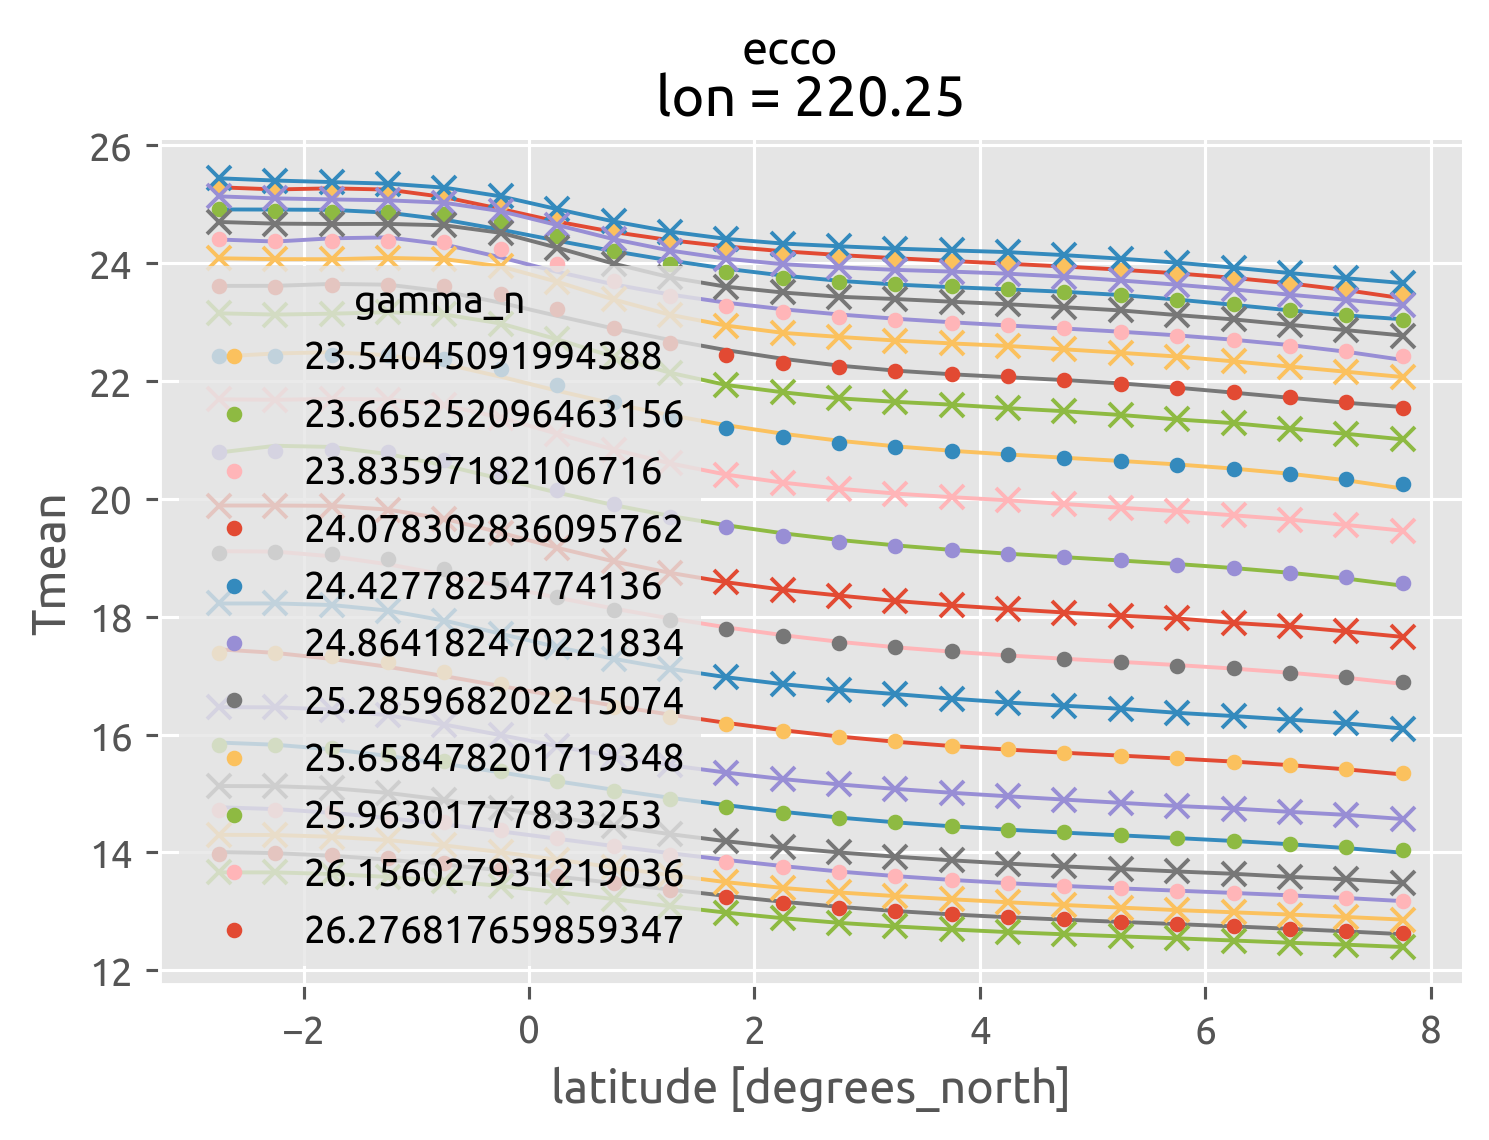

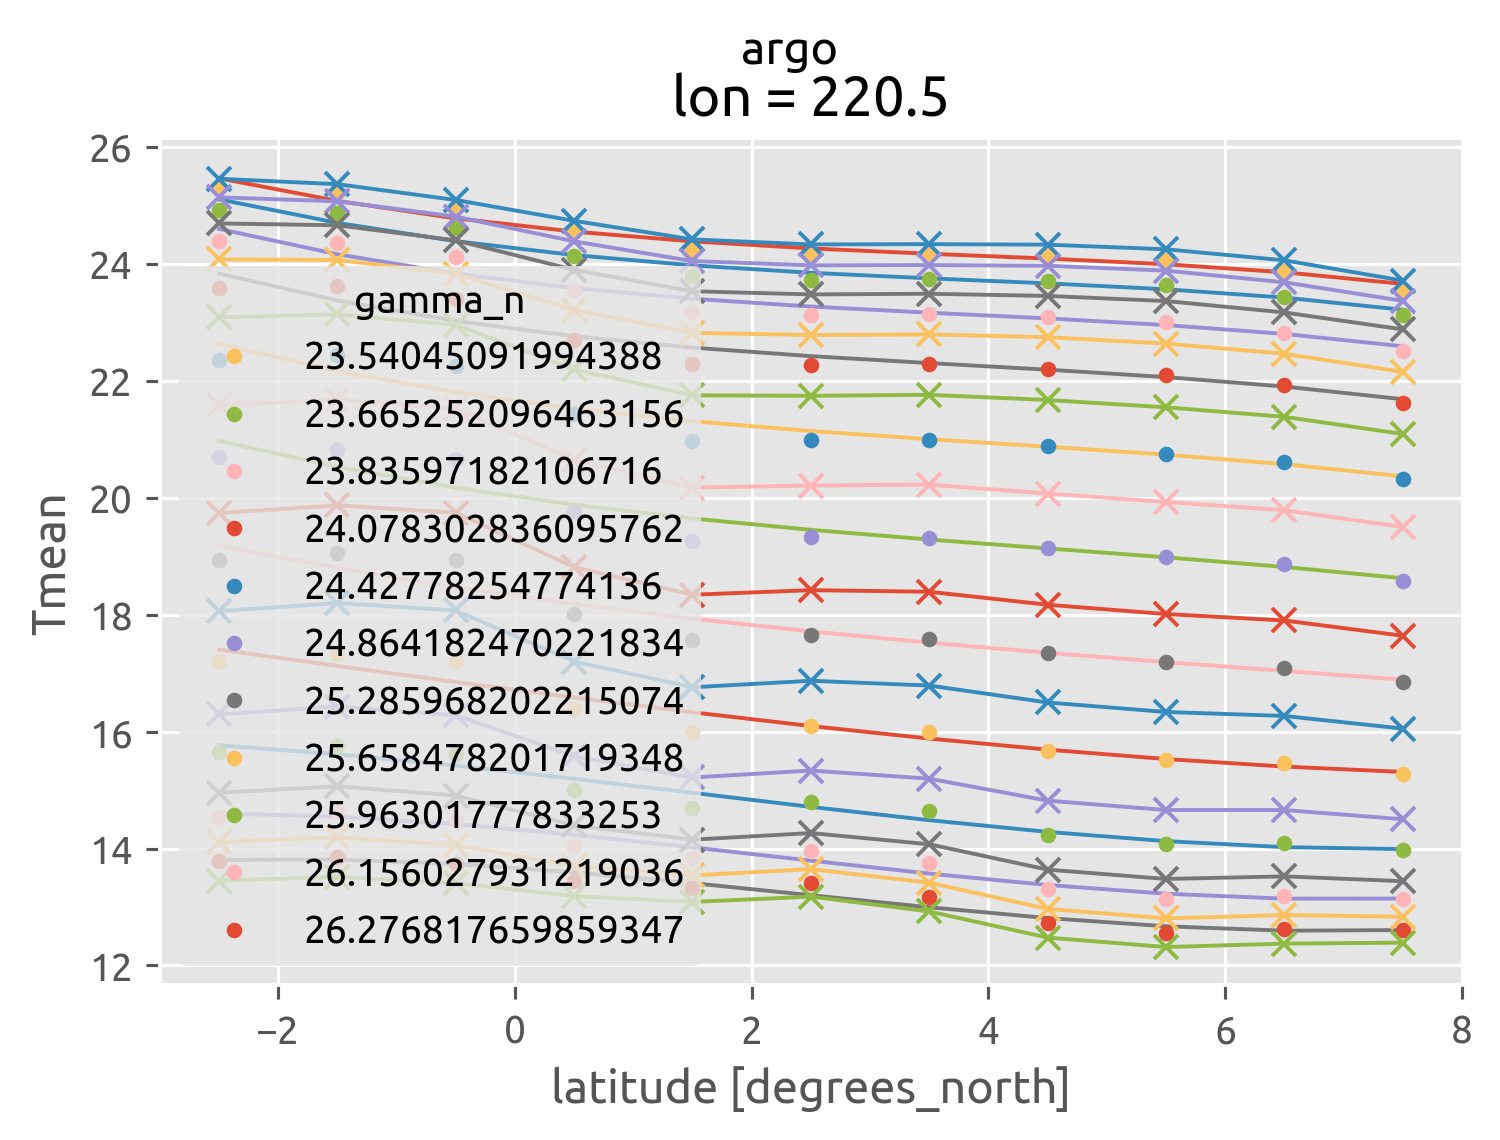

In [35]:
eccoT, edges = ed.estimate_gradients(ecco, bins, bin_var="gamma_n", debug=True)
eccoT = eccoT.interp(lat=0)
argoT, _ = ed.estimate_gradients(argo, bins, bin_var="gamma_n", debug=True)
argoT = argoT.interp(lat=0)
eccoT

In [154]:
chipod_dens_df = ed.eddydiff.bin_avg_in_density_time(
    eop.where(eop.Tz > 5e-3), bins={"neutral_density": bins}, strftime="%Y"
)
chipod_dens = ed.sections.bin_average_vertical(
    eop.where(eop.Tz > 1e-2), "neutral_density", bins, skip_fits=True
)
chipod_dens

<xarray.Dataset>
Dimensions:             (gamma_n: 0, time: 0)
Coordinates:
  * gamma_n             (gamma_n) float64 
  * time                (time) datetime64[ns] 
Data variables: (12/18)
    depth               (gamma_n, time) int64 
    theta               (gamma_n, time) float64 
    chi                 (gamma_n, time) float64 
    eps                 (gamma_n, time) float64 
    Kt                  (gamma_n, time) float64 
    Jq                  (gamma_n, time) float64 
    ...                  ...
    unit                (gamma_n, time) float64 
    pres                (gamma_n, time) float64 
    latitude            (gamma_n, time) int64 
    longitude           (gamma_n, time) int64 
    reference_pressure  (gamma_n, time) int64 
    numobs              (gamma_n, time) int64

In [157]:
eccoT["gamma_n"] = argoT["gamma_n"] = chipod_dens.gamma_n

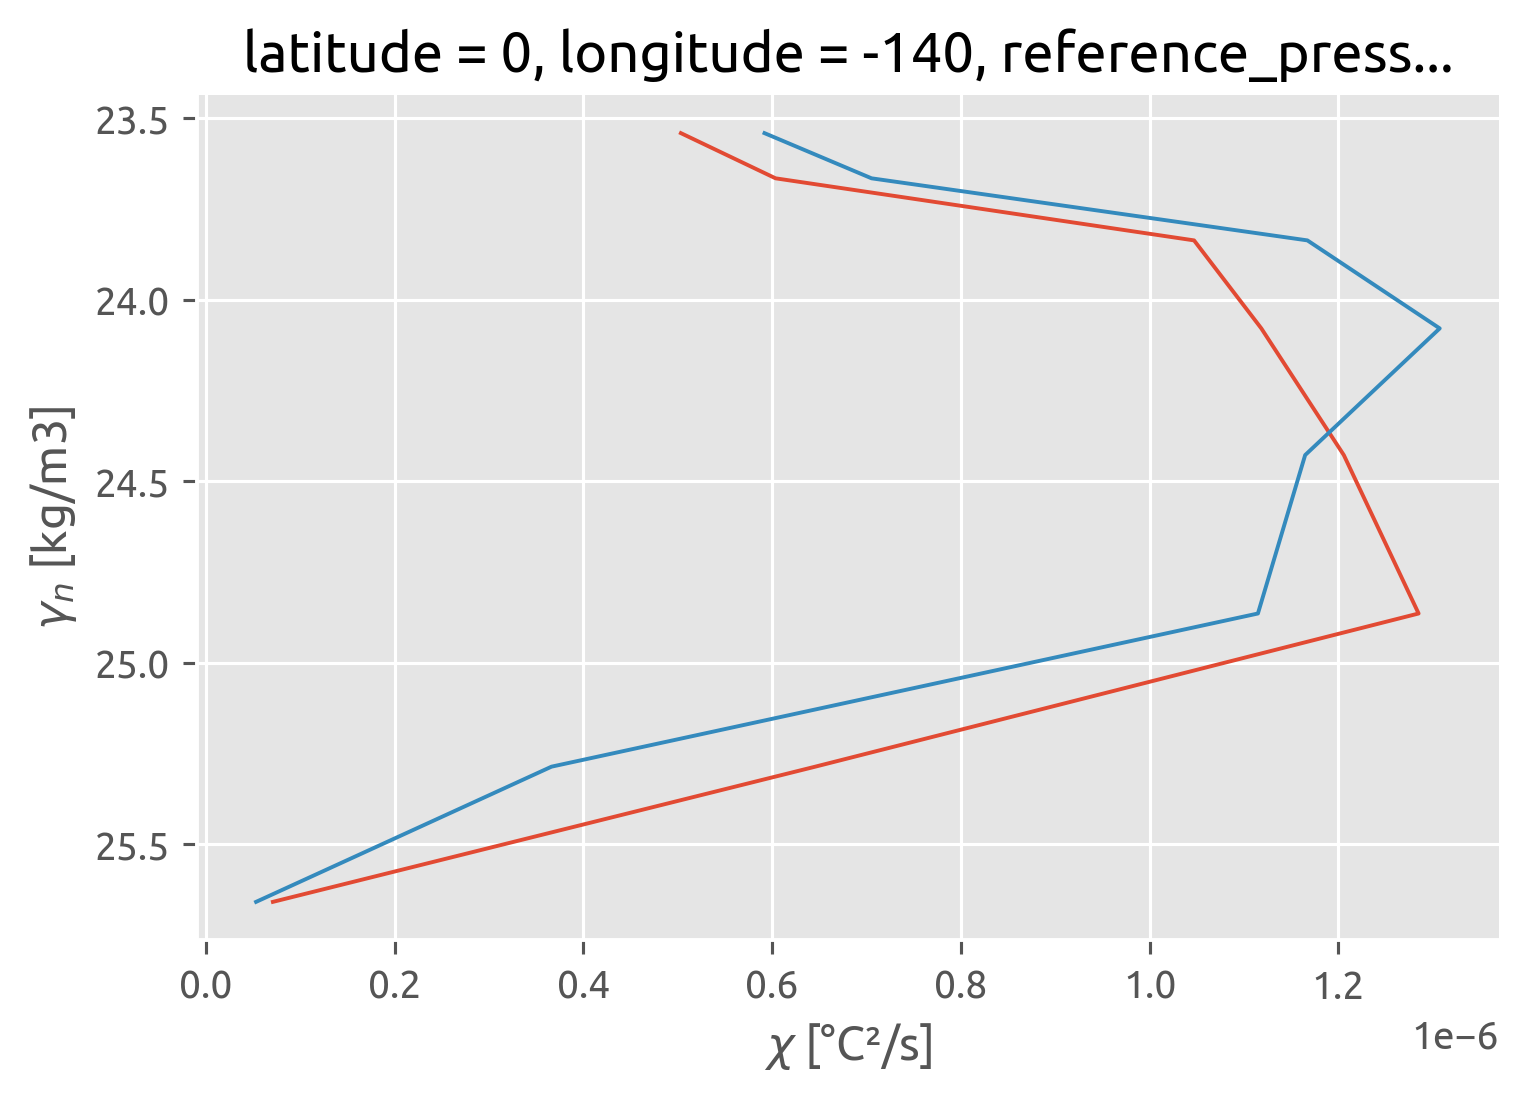

In [158]:
(chipod_dens.chi/2).cf.plot(y="gamma_n")
(chipod_dens.KtTz * eccoT.dTdz).cf.plot(y="gamma_n")

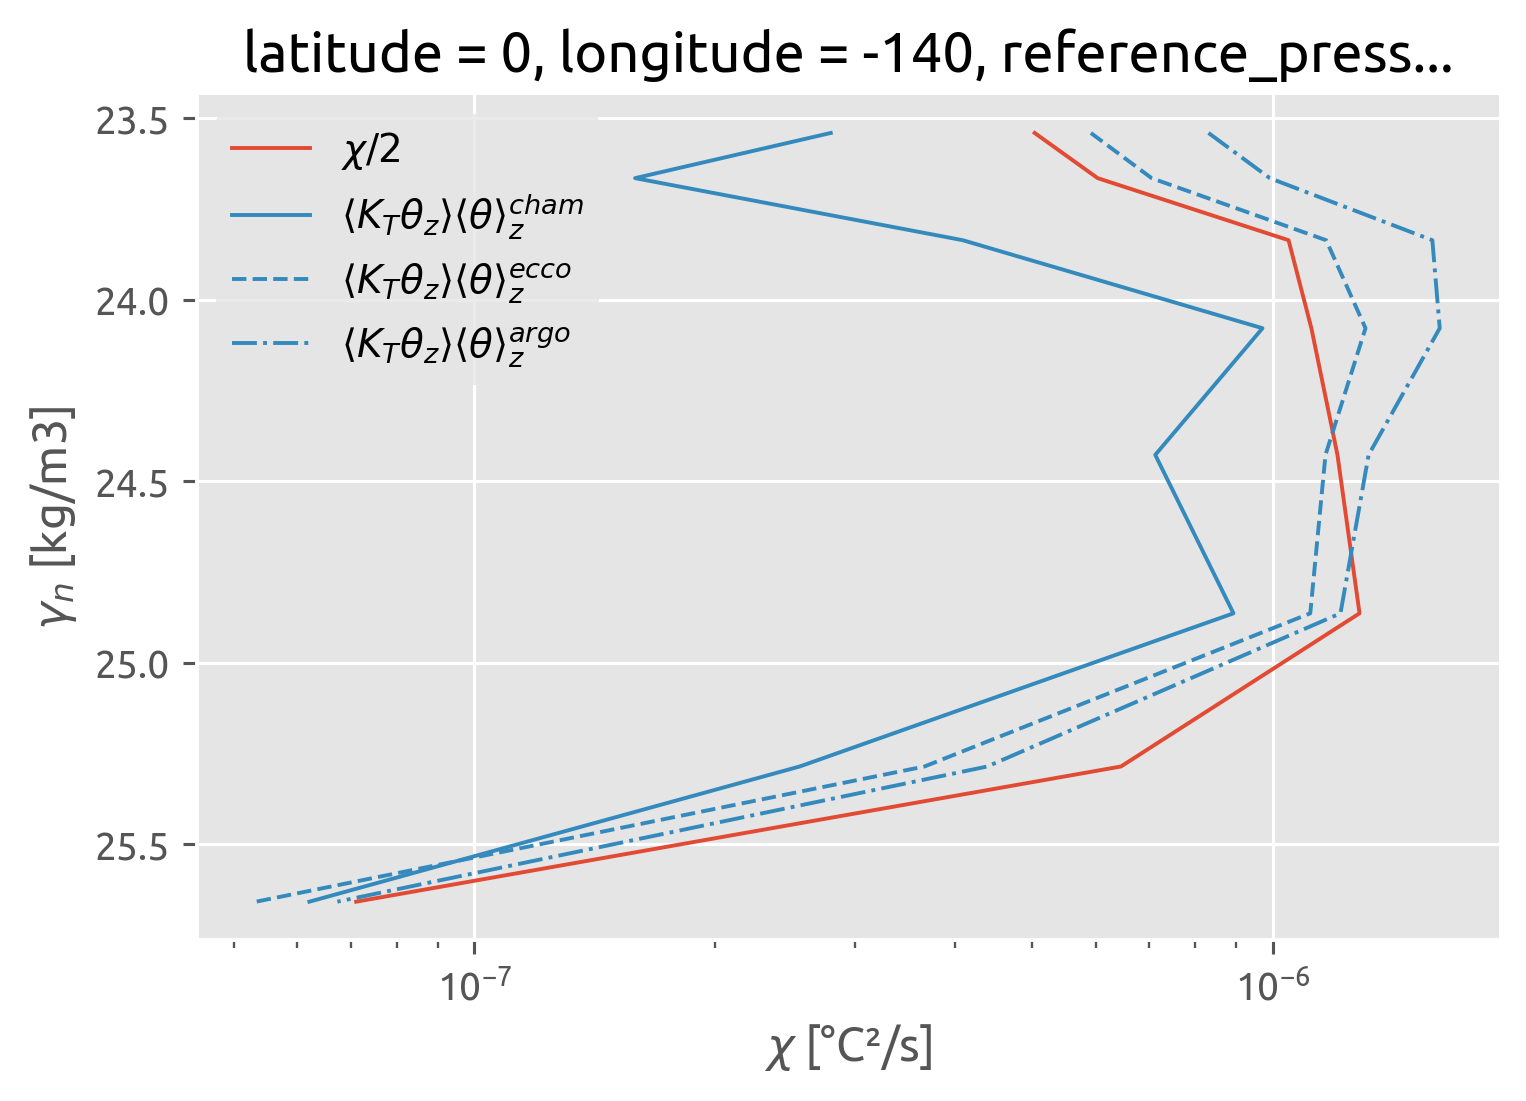

In [160]:
(chipod_dens.chi / 2).cf.plot(y="gamma_n", label="$χ/2$")
(chipod_dens.KtTz * cham_dens.dTdz_m).cf.plot(
    y="gamma_n", xscale="log", label="$⟨K_T θ_z⟩ ⟨θ⟩_z^{cham}$"
)
(chipod_dens.KtTz * eccoT.dTdz).cf.plot(
    y="gamma_n", xscale="log", color="C1", ls="--", label="$⟨K_T θ_z⟩ ⟨θ⟩_z^{ecco}$"
)
(chipod_dens.KtTz * argoT.dTdz).cf.plot(
    y="gamma_n", xscale="log", color="C1", ls="-.", label="$⟨K_T θ_z⟩ ⟨θ⟩_z^{argo}$"
)
plt.legend()

### n-var groupby

In [ ]:
garr = np.array(tuple(tuple_groups))

In [ ]:
out = np.arange(17*5, dtype=float).reshape((17, 5))
result = np.arange(55, dtype=float)
result[mask] = np.nan
out[(garr[:,0], garr[:, 1])] = result
out

In [ ]:
v1 = eop.gamma_n
v2 = eop.time.dt.month

to_group = ((v1, bins), v2)

factorized = []
groups = []
for var in to_group:
    if isinstance(var, tuple):
        # groupby_bins
        var, bins = var
        partitioned = pd.cut(var.data.ravel(), bins)
        cat = partitioned.codes
        uniques = partitioned.categories.values
    else:
        assert isinstance(var, xr.DataArray)  # really duck array
        cat, uniques = pd.factorize(var.data.ravel())

    groups.append(uniques)
    factorized.append(var.copy(data=cat.reshape(var.shape)))

factorized = xr.broadcast(*factorized)

ngroups = len(to_group)
iters = tuple(map(lambda x: x.flat, tuple(g.data for g in factorized)))
tuples = tuple(zip(*iters))
group_idx, tuple_groups = pd.factorize(tuples)
group_idx = group_idx.reshape(factorized[0].shape)
actual_groups = [tuple(g[i] for g, i in zip(groups, idx)) for idx in tuple_groups]
group_idx

In [ ]:
from dask_groupby.core import chunk_reduce

In [ ]:
result = chunk_reduce(eop.chi.data, group_idx, func=("mean",))
#result["groups"] = np.array(actual_groups)#[mask]
#result["mean"] = result["mean"]#[mask]

mask = [-1 not in tup for tup in tuple_groups.flat]
midx = pd.MultiIndex.from_tuples(actual_groups, names=["gamma_n_bins", "month"])[mask]
mean_chi = xr.DataArray(result["mean"][mask], dims="dim", coords={"dim": midx}).unstack()
mean_chi

## Comparing various $T_z$ estimates

First calculate dT/dz using chameleon after remappping to isopycnal bins.

Find mean T, mean z on the isopycnal surfaces. Then do dT/dz.

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


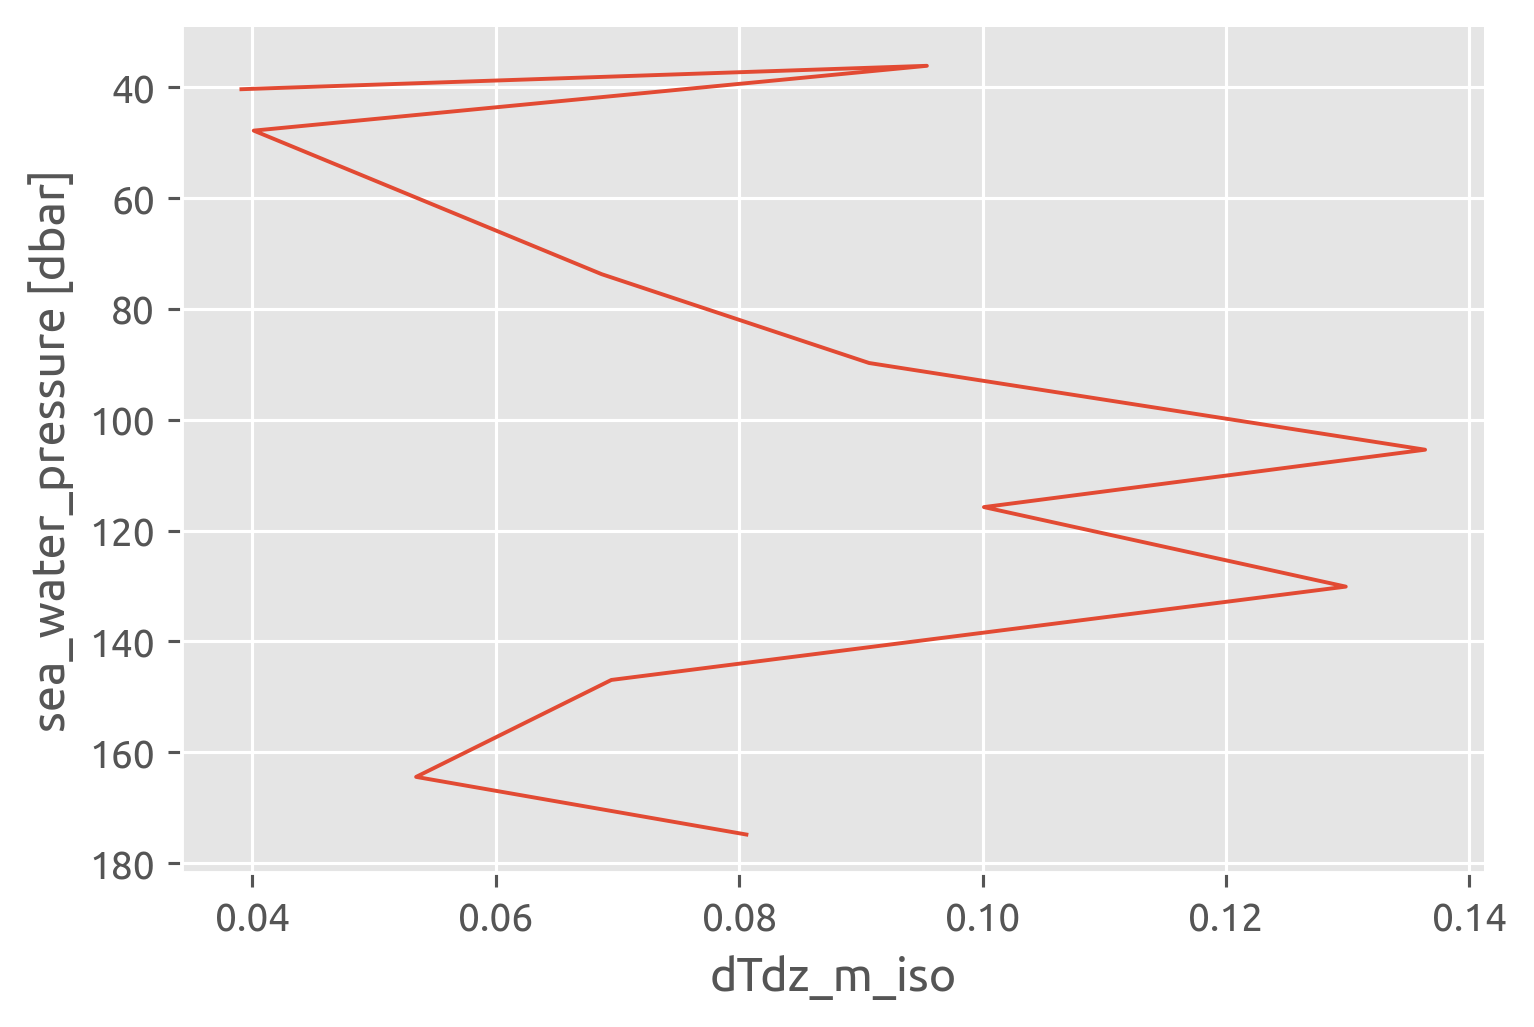

In [157]:
import xgcm

chamgrid = xgcm.Grid(chameleon, periodic=False, coords={"Z": {"center": "depth"}})
isoT = chamgrid.transform(
    chameleon.theta,
    axis="Z",
    target_data=chameleon.gamma_n,
    target=bins,
    method="linear",
)
zT = chamgrid.transform(
    chameleon.depth.broadcast_like(chameleon.gamma_n),
    axis="Z",
    target_data=chameleon.gamma_n,
    target=bins,
    method="linear",
)

cham_dens["dTdz_m_iso"] = (
    "gamma_n",
    (-1 * isoT.mean("time").diff("gamma_n") / zT.mean("time").diff("gamma_n")).data,
)
cham_dens.dTdz_m_iso.cf.plot(y="pres")

This figure compares estimates of the gradient in depth space and isopycnal space, from chameleon and various mean fields.
Summary is that the fitting procedure of Polzin & Ferrari _looks like an underestimate of the mean gradient_. All other estimates are basically the same. That said, even though the fitting results in a lower value it's not that low compared to all the other estimates.

Most interestingly **the chameleon 2 week estimate is basically the same as the argo, ecco climatology estimates**. This means that we can't partition the variance dissipated :/


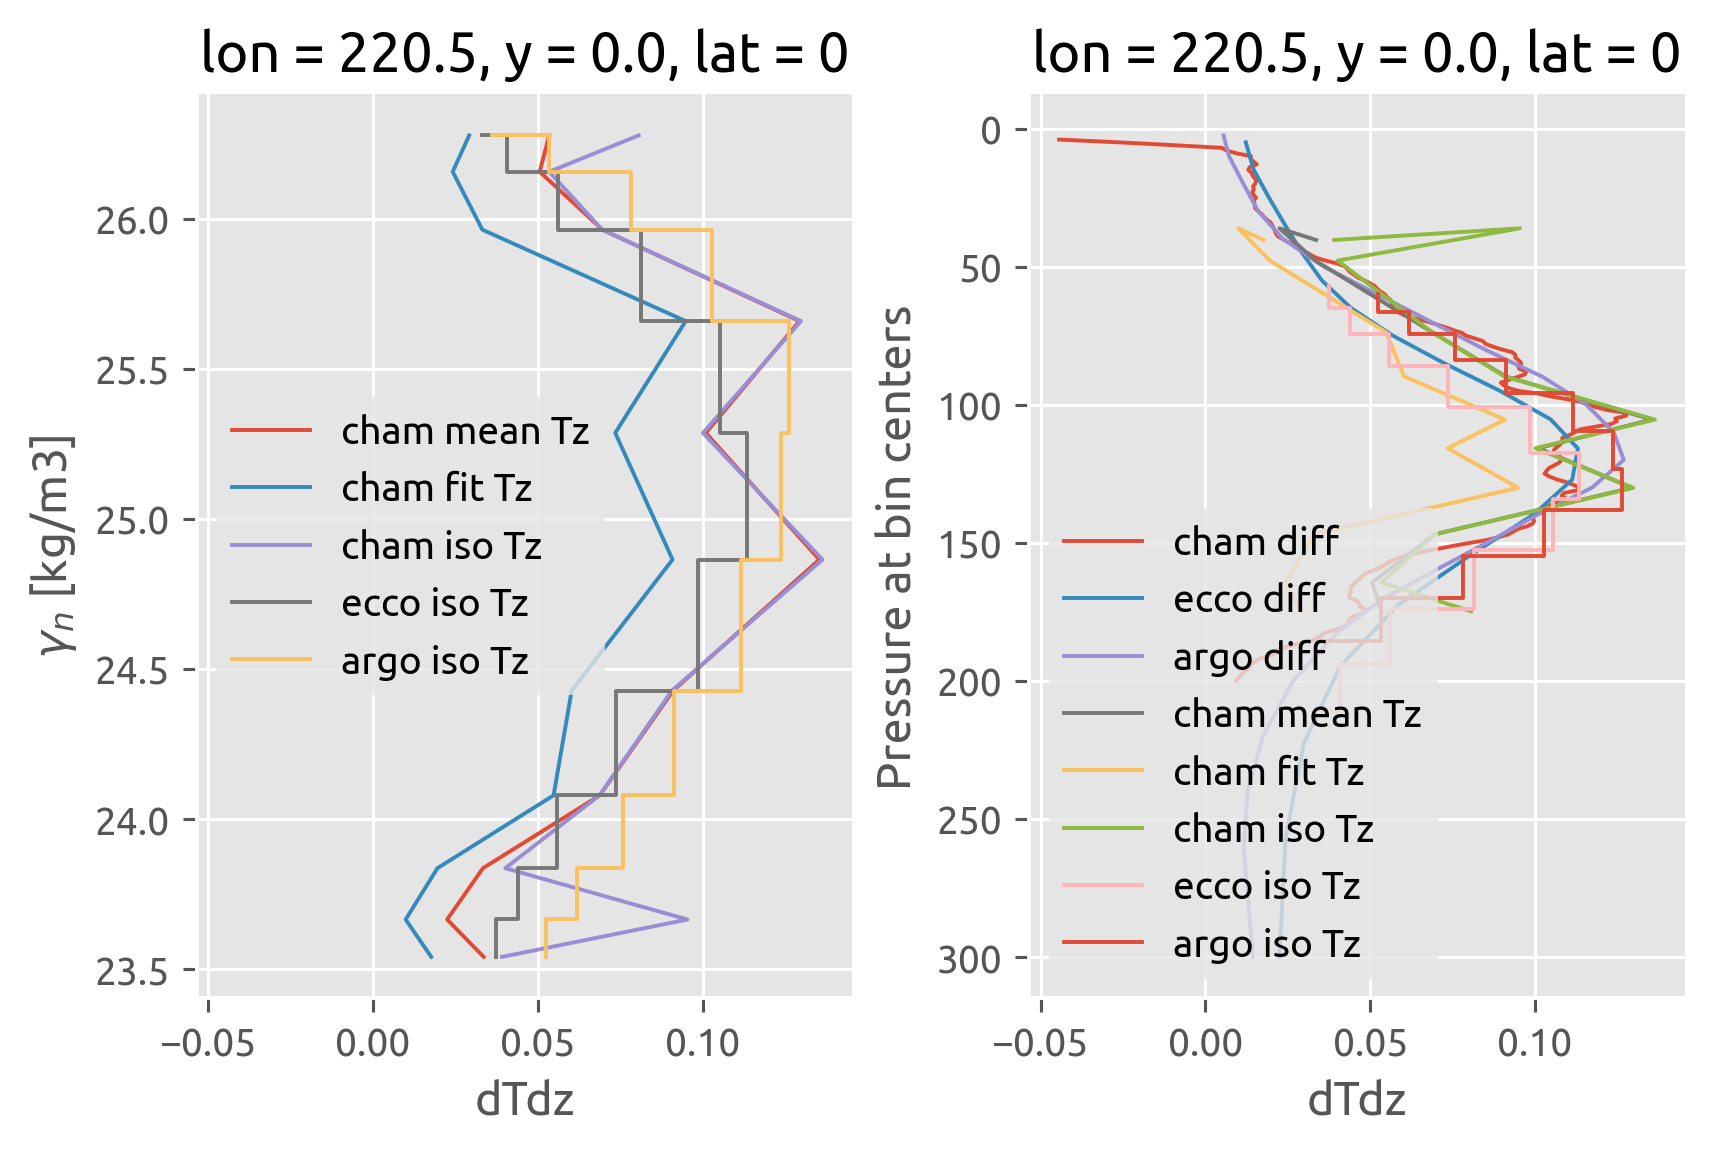

In [171]:
f, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True)

y = "gamma_n"
plt.sca(ax[0])
(cham_dens.Tz).plot(y=y, label="cham mean Tz")
(cham_dens.dTdz_m).plot(y=y, label="cham fit Tz")
cham_dens.dTdz_m_iso.cf.plot(y=y, label="cham iso Tz")
eccoT.dTdz.plot.step(y=y, label="ecco iso Tz")
argoT.dTdz.plot.step(y=y, label="argo iso Tz")
ax[0].legend()

y = "pres"
plt.sca(ax[1])

chameleon.theta.mean("time").cf.differentiate("Z", follow_positive=True).cf.plot(
    label="cham diff"
)
ecco.Tmean.interp(lat=0).cf.differentiate("Z", follow_positive=True).cf.plot(
    label="ecco diff"
)
argo.Tmean.interp(lat=0).cf.differentiate("Z", follow_positive=True).cf.plot(
    label="argo diff"
)
(cham_dens.Tz).plot(y=y, label="cham mean Tz")
(cham_dens.dTdz_m).plot(y=y, label="cham fit Tz")
cham_dens.dTdz_m_iso.cf.plot(y=y, label="cham iso Tz")
eccoT.dTdz.plot.step(y=y, label="ecco iso Tz")
argoT.dTdz.plot.step(y=y, label="argo iso Tz")
ax[1].legend()